In [1]:
from sigvisa.models.spatial_regression.local_regression import LocalGPs, BCM, MultiGPLVM
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample, dgaussian
import scipy.stats
import scipy.optimize
import time

In [2]:
# sample data from the prior
np.random.seed(1)
n = 400
X = np.random.rand(n, 2)

lscale=0.1
noise_var = 0.01
cov = GPCov(wfn_params=[1.0], dfn_params=[lscale, lscale], dfn_str="euclidean", wfn_str="se")
KK = mcov(X, cov, noise_var) 

y = scipy.stats.multivariate_normal(mean=np.zeros((X.shape[0],)), cov=KK).rvs(10)

def vis(X, y):
    for i in range(y.shape[0]):
        figure()
        scatter(X[:, 0], X[:, 1], c=y[i,:], cmap="jet")

observation error 0.0389076772232


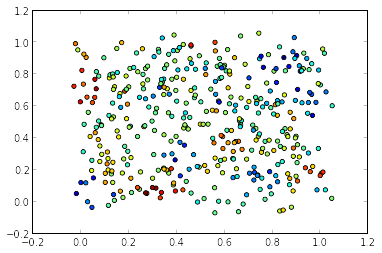

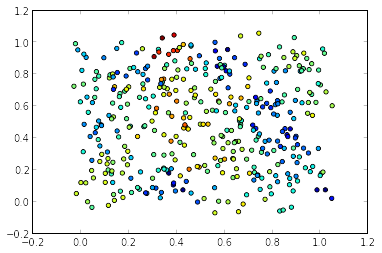

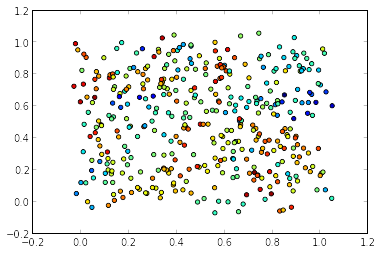

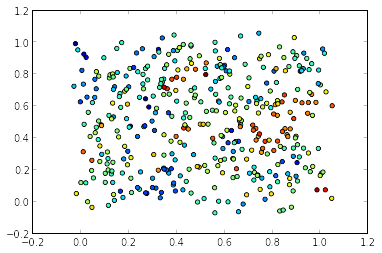

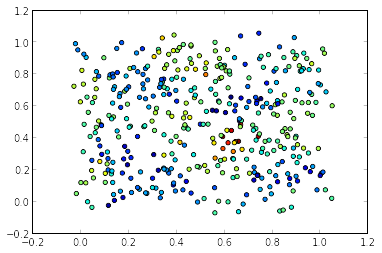

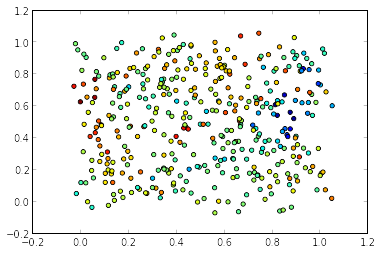

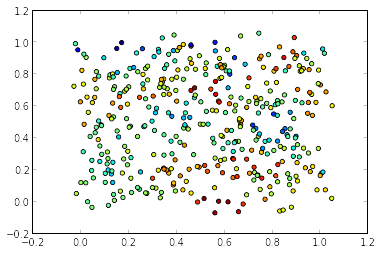

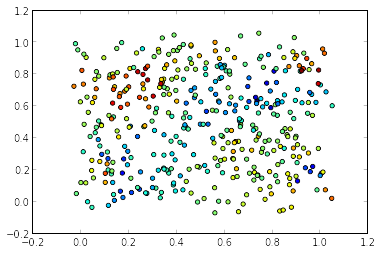

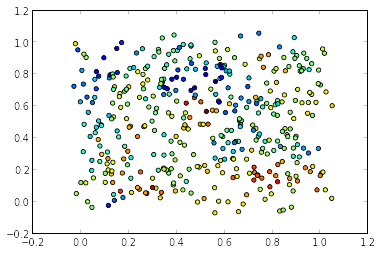

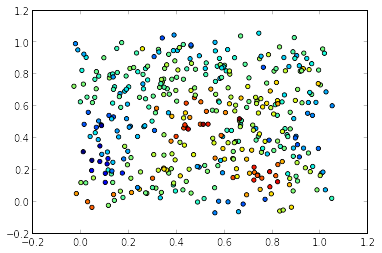

In [3]:
obs_std = 0.05
X_obs = X + np.random.randn(*X.shape)*obs_std


def x_prior(xx):
    flatobs = X_obs.flatten()
    ll = np.sum([scipy.stats.norm(flatobs[i], scale=obs_std).logpdf(xx[i]) for i in range(len(xx))])
    lderiv = np.array([-(xx[i]-flatobs[i])/(obs_std**2) for i in range(len(xx))]).flatten()
    return ll, lderiv

def mean_abs_err(x):
    return np.mean(np.abs(x - X.flatten()))

print "observation error", mean_abs_err(X_obs.flatten())

vis(X_obs, y)

In [ ]:

def gpllgrad(xx):
    X = xx.reshape((-1, 2))
    grad = np.zeros((X.size,))
    ll = 0
    for i in range(y.shape[0]):
        gp = GP(X=X, y=y[i,:].flatten(), noise_var=noise_var, 
                cov_main=cov, compute_ll=True, sort_events=False, 
                compute_grad=False, sparse_invert=False)
        xgrad = gp.grad_ll_wrt_X()
        grad += xgrad.flatten()
        ll += gp.log_likelihood()
    grad = grad.flatten()    
    
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    print ll
    return -ll, -grad


x0 = X_obs.flatten()
r = scipy.optimize.minimize(gpllgrad, x0, jac=True)
print r

print "MAD error", mean_abs_err(r.x)

RX = r.x.reshape(X.shape)
vis(RX, y)

-40071.3259602
-40071.3259602
-2.59908278721e+12
-15929062.8606
-872769.75352
-98919.8711988
-58003.6467923
-41482.4962122
-22997.0523224
-20788.9710026
-17532.8999883
-13809.2713082
-12161.8328444
-10352.5346366
-9176.21335646
-7970.29452139
-7122.0004954
-6380.12866126
-5797.45611599
-5326.2691506
-4869.22460299
-4554.81911168
-4312.54116144
-4063.56005973
-3911.55138423
-3740.54257595
-3624.0918307
-3508.7047028
-3428.10449974
-3367.38215896
-3339.6590637
-3301.31188406
-3257.13085694
-3217.43808234
-3182.31569938
-3153.19402071
-3122.15577598
-3117.37901249
-3109.01745799
-3095.54578087
-3078.90108139
-3062.58577104
-3055.04979015
-3045.17904803
-3037.33921401
-3030.37582561
-3025.01667551
-3018.6091288
-3010.29659945
-3004.90938009
-3003.88810496
-3002.03355672
-2998.90331592
-2994.07748929
-2988.4654835
-2981.62984422
-2978.42500076
-2974.90574254
-2970.28448528
-2965.42535574
-2966.07562542
-2963.00946413
-2961.62206628

In [4]:
def vec(s1, s2):
    return np.array((scalar,), dtype=np.float)

# 15 gives 49 clusters (7**2)~=(15/2)**2, suitable for 2000 points
# 9 gives 16 clusters (4**2), suitable for 256 points
# 11      25                               625
pts = np.linspace(0, 1, 9)[1::2]
centers = [np.array((xx, yy)) for xx in pts for yy in pts]

lgps = LocalGPs(block_centers=centers, cov_block_params = [(noise_var, 1.0, lscale, lscale)], X=X, y=y[0,:])
bcm = BCM(block_centers=centers, cov_block_params = [(noise_var, 1.0, lscale, lscale)], X=X, y=y[0,:], test_cov=cov)

gp = GP(X=X, y=y[0,:].flatten(), noise_var=noise_var, 
                cov_main=cov, compute_ll=True, sort_events=False, 
                compute_grad=False, sparse_invert=False)
print lgps.likelihood()
print bcm.likelihood()
print gp.log_likelihood()

-131.626683053
-41.4909175949
-48.8779853044


In [4]:
# TODO: gplvm with local GPs

mlgps = MultiGPLVM(X=X, Y=y, cov_block_params = np.array(([noise_var, 1.0, lscale, lscale],)), 
                   bcm=False, block_centers=centers)

def lgpllgrad(xx):
    mlgps.update_X(xx)
    ll = mlgps.likelihood()
    grad = mlgps.llgrad_X().flatten()
    #print ll, xx
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    
    return -ll, -grad

t0 = time.time()
x0 = X_obs.flatten()
r = scipy.optimize.minimize(lgpllgrad, x0, jac=True)
t1 = time.time()
print "local GPs optimized in ", t1-t0, "seconds"
print r

print "MAD error", mean_abs_err(r.x)


-131.626683053
-41.4909175949
-48.8779853044


In [ ]:
# TODO: gplvm with local GPs

mlgps = MultiGPLVM(X=X, Y=y, cov_block_params = np.array(([noise_var, 1.0, lscale, lscale],)), 
                   bcm=True, block_centers=centers, test_cov=cov)

def bcmllgrad(xx):
    mlgps.update_X(xx)
    ll = mlgps.likelihood()
    grad = mlgps.llgrad_X().flatten()
    print ll
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    
    return -ll, -grad

t0 = time.time()
x0 = X_obs.flatten()
r = scipy.optimize.minimize(bcmllgrad, x0, jac=True)
t1 = time.time()
print "BCM optimized in ", t1-t0, "seconds"
print r

print "MAD error", mean_abs_err(r.x)


-41618.7458487
-41618.7458487

(0.01, se[ 1.], euclidean[ 0.2  0.2])
se[ 1.], euclidean[ 0.1  0.1]
